# Sky Maps

In this notebook we will have a deeper look at the gamma-ray distribution in the sky. We will obtain an estimate of the background that we can subtract from our sky map to obtain the gamma-ray excess and significance. Along the way we will learn about Makers in gammapy and how to combine several observation runs.

Our final products will be a significance map, an exclusion map that flags sky regions that are not to be used for background estimation, and a map data set for later use.

## Imports

Let's start with importing ther modules and classes that we have seen in the last session.

In [1]:
import os

import matplotlib.pyplot as plt

import numpy as np

from numpy import sqrt

import astropy.units as u

from astropy.coordinates import (
    SkyCoord, 
    Angle,
)

from gammapy.utils.check import check_tutorials_setup

from gammapy.data import (
    DataStore,
)

from gammapy.stats import WStatCountsStatistic

from gammapy.maps import Map

## Check the Data

In [2]:
if not os.path.exists('gammapy-data'):
    check_tutorials_setup()
else:
    print('Great your setup is correct!')

Great your setup is correct!


In [3]:
os.environ['GAMMAPY_DATA'] = 'gammapy-data/1.2'

In [4]:
data_store = DataStore.from_dir('$GAMMAPY_DATA/hess-dl3-dr1')

In [5]:
data_store.info()

Data store:
HDU index table:
BASE_DIR: gammapy-data/1.2/hess-dl3-dr1
Rows: 630
OBS_ID: 20136 -- 47829
HDU_TYPE: ['aeff', 'bkg', 'edisp', 'events', 'gti', 'psf']
HDU_CLASS: ['aeff_2d', 'bkg_3d', 'edisp_2d', 'events', 'gti', 'psf_table']


Observation table:
Observatory name: 'N/A'
Number of observations: 105



## Run Selection

In [6]:
source_pos = SkyCoord(83.633*u.deg, 22.014*u.deg, frame='icrs')

In [7]:
selectradius = 2.5*u.deg

In [8]:
conesearch = data_store.obs_table.select_sky_circle(source_pos, selectradius)

In [9]:
runlist = conesearch['OBS_ID'].value

In [10]:
observations = data_store.get_observations(runlist)

In [11]:
observations.ids

['23523', '23526', '23559', '23592']

In [12]:
obs = observations[0]

In [13]:
obs

## Geometries

In the last notebook we binned all events into a two-dimensional map with coordinates Right Ascension and Declination:

In [14]:
map_crab = Map.create(binsz=0.01*u.deg, 
                      width=(5*u.deg, 5*u.deg), 
                      skydir=source_pos, 
                      frame='icrs')

The axes of our map are stored in a geometry:

In [15]:
map_crab.geom

We now want to bin the events into RA, Dec and energy. We will need a three-dimensional geometry.

In [16]:
# minimum and maximum energy for the analysis
Emin = 0.1*u.TeV
Emax = 50*u.TeV

# number of energy bins in the map
map_nEbins = 9

# width of the map
map_width = 8*u.deg

# bin size of the map
map_binsz = 0.025*u.deg

In [17]:
from gammapy.maps import MapAxis, WcsGeom

In [18]:
map_energy_axis = MapAxis.from_energy_bounds(Emin, Emax,
                                             nbin=map_nEbins, 
                                             name='energy')

map_geom = WcsGeom.create(skydir=source_pos,
                          width=map_width,
                          binsz=map_binsz,
                          axes=[map_energy_axis]
                         )

In [19]:
map_geom

In [20]:
#We will also need an axis for true energy:

energy_axis_true = MapAxis.from_energy_bounds(0.08*u.TeV, 80*u.TeV,
                                              nbin=8,
                                              per_decade=True,
                                              name='energy_true')

### MapDatasetMaker
We will now use gammapy code to do the binning of our event lists. Objects that manipulate data in gammapy are called Makers. We start with a DatasetMaker.

In [21]:
from gammapy.datasets import MapDataset

from gammapy.makers import MapDatasetMaker

In [22]:
map_empty = MapDataset.create(map_geom, 
                              name='empty', 
                              energy_axis_true=energy_axis_true
                             )

In [23]:
map_maker = MapDatasetMaker()

We will test everything on the first run:

In [24]:
map_dataset = map_maker.run(map_empty, obs)

/home/komin/anaconda3/envs/gammapy-1.2/lib/python3.10/site-packages/gammapy/utils/interpolation.py:197: RuntimeWarning: overflow encountered in exp
  output = np.exp(values)


array([[<WCSAxes: title={'center': 'Energy 100 GeV - 199 GeV'}>,
        <WCSAxes: title={'center': 'Energy 199 GeV - 398 GeV'}>,
        <WCSAxes: title={'center': 'Energy 398 GeV - 794 GeV'}>],
       [<WCSAxes: title={'center': 'Energy 794 GeV - 1.58 TeV'}>,
        <WCSAxes: title={'center': 'Energy 1.58 TeV - 3.16 TeV'}>,
        <WCSAxes: title={'center': 'Energy 3.16 TeV - 6.30 TeV'}>],
       [<WCSAxes: title={'center': 'Energy 6.30 TeV - 12.6 TeV'}>,
        <WCSAxes: title={'center': 'Energy 12.6 TeV - 25.1 TeV'}>,
        <WCSAxes: title={'center': 'Energy 25.1 TeV - 50.0 TeV'}>]],
      dtype=object)

/home/komin/anaconda3/envs/gammapy-1.2/lib/python3.10/site-packages/astropy/visualization/mpl_normalize.py:179: RuntimeWarning: invalid value encountered in divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/home/komin/anaconda3/envs/gammapy-1.2/lib/python3.10/site-packages/astropy/visualization/mpl_normalize.py:179: RuntimeWarning: invalid value encountered in divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/home/komin/anaconda3/envs/gammapy-1.2/lib/python3.10/site-packages/astropy/visualization/mpl_normalize.py:179: RuntimeWarning: invalid value encountered in divide
  np.true_divide(values, self.vmax - self.vmin, out=values)


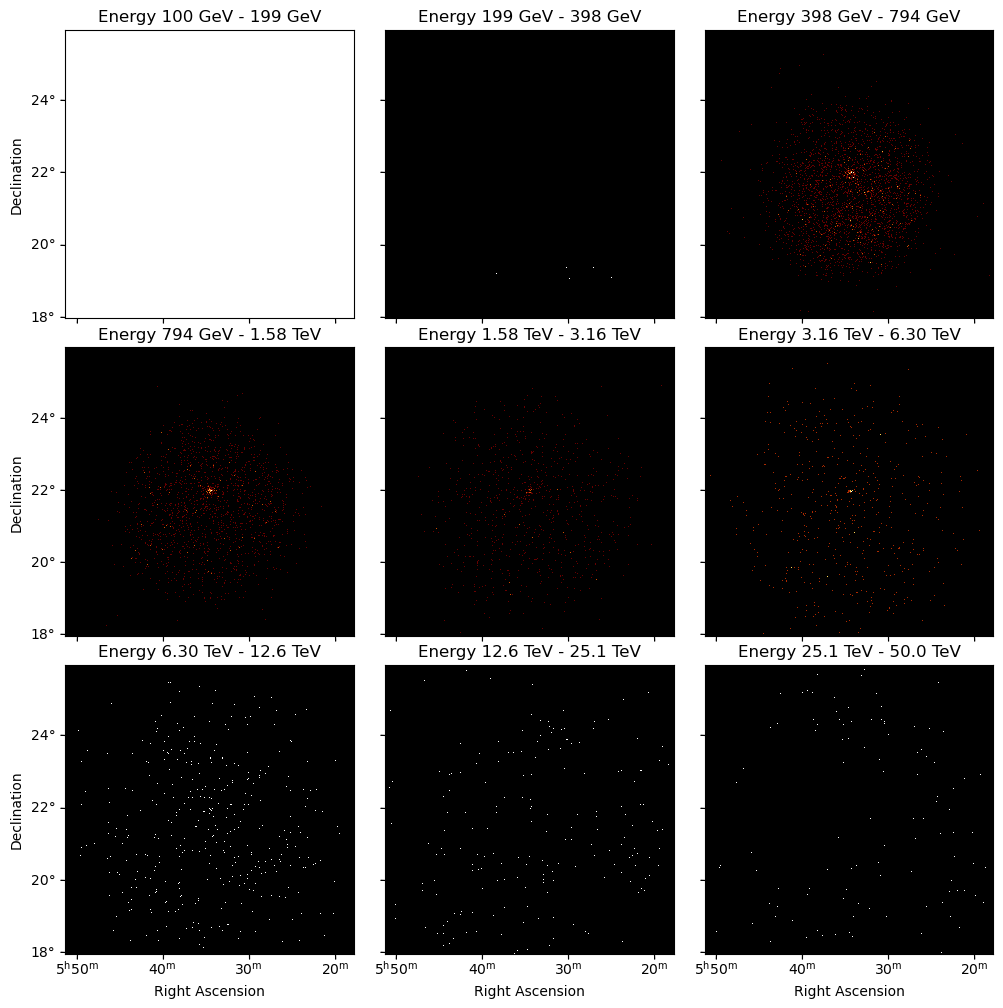

In [25]:
map_dataset.counts.plot_grid()

In [26]:
#map_dataset.counts_off

### SafeMaskMaker
We want to reject badly reconstructed events. This could be events with a very large distance from the camera centre (outside the camera) or at low energies where the sensitivity of the instruments is too low. We will reject all events outside a radius of 2.5 deg and where the sensitivity drops below 10% of the maximum value. The SafeMaskMaker will do that for us.

In [27]:
# maximumum offset
offset_max = 2.5*u.deg

aeff_max = 10

<WCSAxes: >

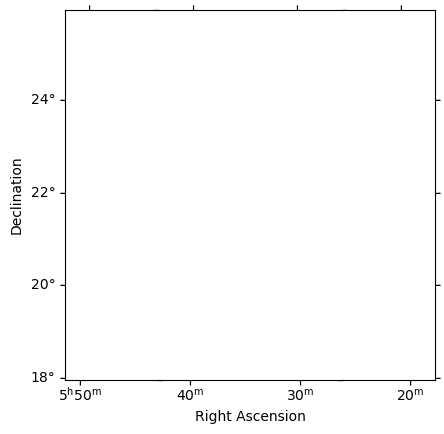

In [28]:
map_dataset.mask_image.plot()

In [29]:
from gammapy.makers import SafeMaskMaker

In [30]:
safe_mask_maker = SafeMaskMaker(methods=['offset-max', 'aeff-max'], 
                                offset_max = offset_max,
                                aeff_percent = aeff_max
                               )

In [31]:
map_dataset = safe_mask_maker.run(map_dataset, obs)

<WCSAxes: >

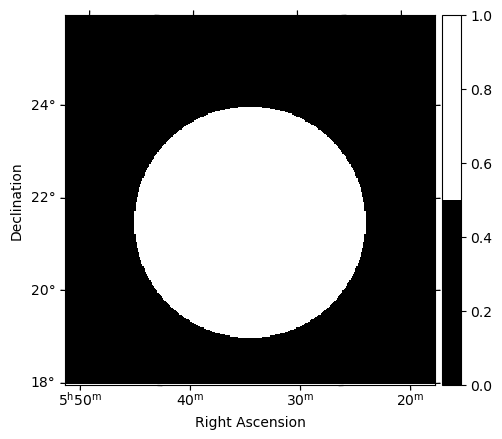

In [32]:
map_dataset.mask_image.plot(add_cbar = True)

array([[<WCSAxes: title={'center': 'Energy 100 GeV - 199 GeV'}>,
        <WCSAxes: title={'center': 'Energy 199 GeV - 398 GeV'}>,
        <WCSAxes: title={'center': 'Energy 398 GeV - 794 GeV'}>],
       [<WCSAxes: title={'center': 'Energy 794 GeV - 1.58 TeV'}>,
        <WCSAxes: title={'center': 'Energy 1.58 TeV - 3.16 TeV'}>,
        <WCSAxes: title={'center': 'Energy 3.16 TeV - 6.30 TeV'}>],
       [<WCSAxes: title={'center': 'Energy 6.30 TeV - 12.6 TeV'}>,
        <WCSAxes: title={'center': 'Energy 12.6 TeV - 25.1 TeV'}>,
        <WCSAxes: title={'center': 'Energy 25.1 TeV - 50.0 TeV'}>]],
      dtype=object)

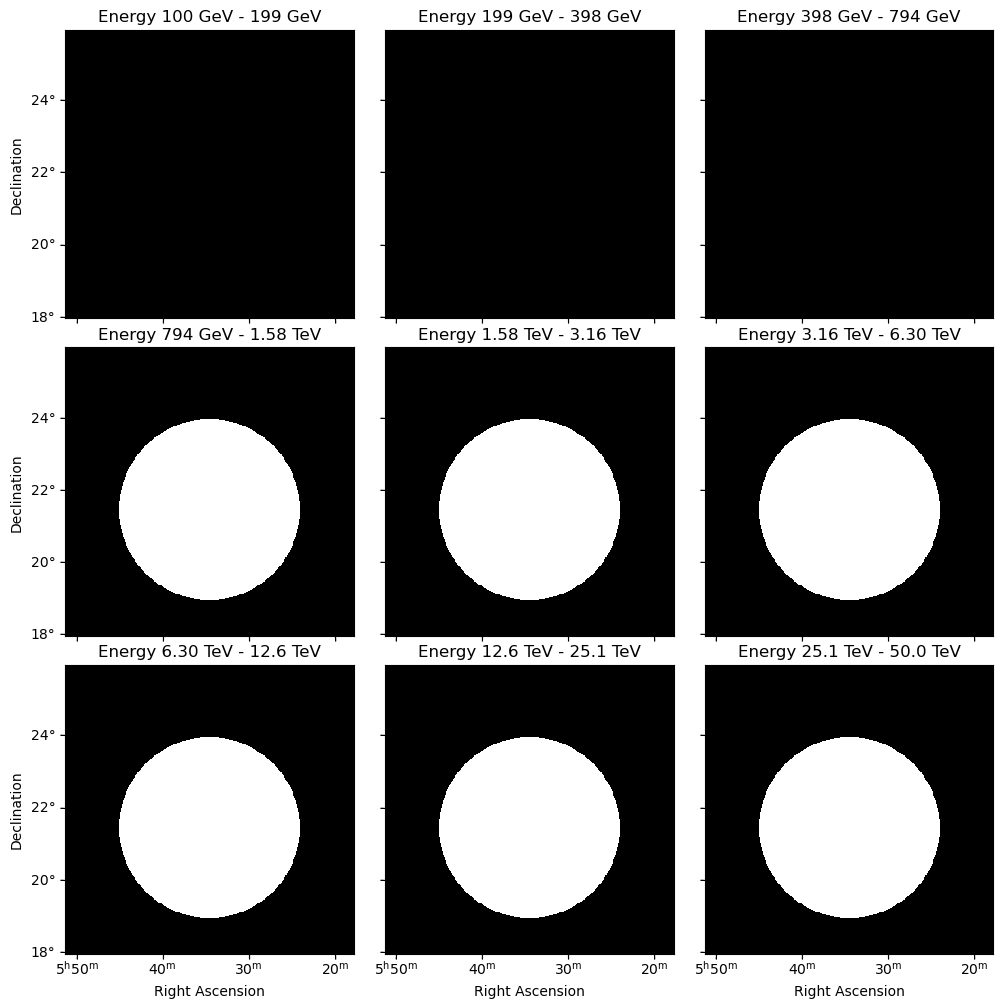

In [33]:
map_dataset.mask_safe.plot_grid()

### Ring Background
Finally we use the RingBackgroundMaker to create a background estimate. First we need an exclusion mask which flags all known and potential sources.

Let's start with a guess on the exclusion radius.

In [34]:
exclusion_radius = 0.1*u.deg

In [35]:
from regions import CircleSkyRegion

In [36]:
exclusion_regions = [CircleSkyRegion(center=source_pos,  ## exclude the Crab Nebula
                                     radius=exclusion_radius
                                    ),  
                     CircleSkyRegion(center=SkyCoord(183.604, -8.708,       
                                                     ## RGB J0521+212, recommended in gammapy tutorial
                                                     unit='deg', 
                                                     frame='galactic'),
                                     radius=exclusion_radius)
                    ]

In [37]:
exclusion_regions

[<CircleSkyRegion(center=<SkyCoord (ICRS): (ra, dec) in deg
     (83.633, 22.014)>, radius=0.1 deg)>,
 <CircleSkyRegion(center=<SkyCoord (Galactic): (l, b) in deg
     (183.604, -8.708)>, radius=0.1 deg)>]

In [38]:
exclusion_mask = map_geom.to_image().region_mask(exclusion_regions, inside = False) 

<WCSAxes: >

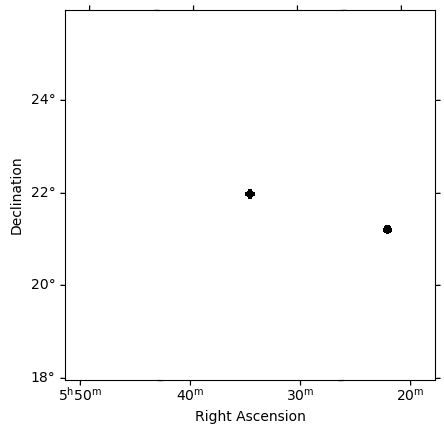

In [39]:
exclusion_mask.plot()

Now we create the RingBackgroundMaker. We can choose the inner radius of the ring, which must be larger than the largest exclusion region, and the width of the ring.

In [ ]:
from gammapy.makers import RingBackgroundMaker

In [ ]:
ring_bkg_maker = RingBackgroundMaker(exclusion_mask=exclusion_mask,
                                     r_in=exclusion_radius,
                                     width=0.4*u.deg)

In [ ]:
map_dataset = ring_bkg_maker.run(map_dataset)

In [ ]:
map_dataset.counts.plot_grid()

In [ ]:
map_dataset.counts_off.plot_grid()

In some images we can see the rings of the background estimator! This also means that we do not have sufficient background counts in these images. We may need to consider larger energy bins at a later stage.

These objects can get quite large. So we need to do a bit of memory management. We delete this object as we don't need it anymore.

In [ ]:
del map_dataset

### Combination of all runs
We now loop over all runs and stack the individual data sets. We have already defined the makers that we want to run. We want to the makers on all observations. Rather than a simple for loop (which would work), we would like to have the option to run in parallel. The ```DatasetsMaker``` provides this functionality.

In [ ]:
from gammapy.makers import DatasetsMaker

In [ ]:
chainmaker_map = DatasetsMaker(makers = [map_maker, safe_mask_maker, ring_bkg_maker],
                               stack_datasets = False,
                               n_jobs = 4, parallel_backend = 'multiprocessing'
                               )

In [ ]:
## I strongly suggest to keep these two lines in a single cell
## to make sure that the stacked map is deleted before running the chain again.

#map_stacked = map_empty.copy(name = 'stacked')
#map_stacked = MapDatasetOnOff.from_geoms(**map_empty.geoms)

map_datasets = chainmaker_map.run(dataset = map_empty.copy(name = 'stacked'), ## this will not be used
                                  observations = observations)

We want to stack all the observations into a dataset with the previously defined geometry.

In [ ]:
from gammapy.datasets import MapDatasetOnOff

In [ ]:
map_stacked = MapDatasetOnOff.from_geoms(**map_empty.geoms)

for ds in map_datasets :
    map_stacked.stack(ds)

In [ ]:
del map_datasets

## A Quick Look at the Maps

In [ ]:
map_stacked.counts.plot_grid()

In [ ]:
map_on = map_stacked.counts.sum_over_axes()

In [ ]:
map_on.plot(add_cbar = True, cmap = 'plasma')

In [ ]:
map_on.smooth(0.05*u.deg).plot(add_cbar = True,
                               cmap = 'plasma')

#plt.savefig('MapOn.svg')

In [ ]:
map_stacked.counts_off.plot_grid()

In [ ]:
map_stacked.alpha.plot_grid()

In [ ]:
map_off = (map_stacked.counts_off * map_stacked.alpha).sum_over_axes()

In [ ]:
map_off.plot(add_cbar = True)

In [ ]:
map_off.smooth(0.05*u.deg).plot(add_cbar = True,
                                cmap = 'plasma')

#plt.savefig('MapOff.svg')

In [ ]:
map_excess = map_on - map_off

In [ ]:
map_excess.plot(add_cbar = True)

In [ ]:
map_excess.smooth(0.05*u.deg).plot(add_cbar = True,
                                   cmap = 'plasma')

#plt.savefig('MapExcess.svg')

In [ ]:
map_stacked.peek()

## Excess and Significance Maps

We have seen a very simple way to get the excess map. We could also calculate the significance in each bin. 
But there is a simpler way to do all that. We can use gammapy's ExcessMapEstimator.

In [ ]:
from gammapy.estimators import ExcessMapEstimator

The ExcessMapEstimator uses oversampling. So we need to decide our oversampling radius. For that we should have a look at our point-spread function (PSF).

In [ ]:
map_stacked.psf.plot_containment_radius_vs_energy(fraction=(0.34, 0.68, 0.95, 0.99))

The 68% radius is often a good choice. But the Crab Nebula is so bright that we can go lower than that. Let's take 0.05 deg.

In [ ]:
estimator = ExcessMapEstimator(0.05*u.deg)

fluxmaps = estimator.run(map_stacked)

In [ ]:
fluxmaps.npred_excess.plot(add_cbar = True, cmap = 'plasma')

#plt.savefig('FinalMap_Excess.svg')

In [ ]:
fluxmaps.sqrt_ts.plot(add_cbar = True, cmap = 'plasma')

#plt.savefig('FinalMap_Significance.svg')

This is our significance map. Let's keep this for later:

In [ ]:
fluxmaps.sqrt_ts

In [ ]:
significance_map = fluxmaps.sqrt_ts.reduce_over_axes()

In [ ]:
fluxmaps.flux.plot(add_cbar = True, cmap = 'plasma')

#plt.savefig('FinalMap_Flux.svg')

#### your playground
Please try different convolution radii. You will see that smaller radii will lead to a more noisy image and larger radii will make the source appear bigger. This does not mean that the source is indeed bigger. You just smear out the emission over a larger area.

In [ ]:
## your code here

### Evaluation of the Sky Map
We need to check that our background estimate is reasonable and we would like to know if there are any other potential sources in the map.

We will make a histogram of the significance distribution. This will require some data manipulation.

In [ ]:
sigmapdata = significance_map.data

In [ ]:
sigmapdata

In [ ]:
sigmapdata = sigmapdata.ravel()

In [ ]:
sig_hist = plt.hist(sigmapdata,
                    bins = 50,
                    density = True,
                    color = 'tab:blue'
                   )

plt.yscale('log')

#plt.savefig('SigDist_all.svg')

We clearly see that there are bins with significances up to 30 sigma (this is the Crab Nebula). We also see many bins with significances around 0 (this is in the parts of the image with no source, which is our background). We can also study the regions containing only background, we need to multiply the significance image with the exclusion mask. 

In [ ]:
sig_off = significance_map*exclusion_mask

In [ ]:
sig_off.plot(add_cbar = True,
             cmap = 'plasma'
            )

#plt.savefig('SigMap_masked.svg')

In [ ]:
sigmapdata_off = sig_off.data.ravel()

In [ ]:
sig_hist_off = plt.hist(sigmapdata_off,
                        bins = sig_hist[1],
                        density = True
                       )

plt.yscale('log')

This should be a Gaussian centred on 0 with a width of 1. Let's test it.

In [ ]:
from scipy.stats import norm

In [ ]:
mu, std = norm.fit(sigmapdata_off)

print(f'Fit results: mu = {mu:.2f}, std = {std:.2f}')

In [ ]:
x = np.linspace(-5, 5, 50)
p = norm.pdf(x, mu, std)

In [ ]:
plt.stairs(sig_hist_off[0], sig_hist_off[1],
           fill = True,
           color = 'tab:red'
          )

plt.plot(x, p, lw=2, color='black')

plt.yscale('log')

#plt.savefig('SigDist_off.svg')

In [ ]:
plt.stairs(sig_hist[0], sig_hist[1],
           fill = True,
           color = 'tab:blue',
           label='all bins'
          )

plt.stairs(sig_hist_off[0], sig_hist_off[1],
           fill = True,
           color = 'tab:red',
           label = 'off bins',
           alpha = 0.5
          )

plt.plot(x, p, lw=2, color='black', 
         label = f'mu = {mu:.2f}, std = {std:.2f}')

plt.yscale('log')

plt.xlabel('significance')

plt.legend()

#plt.savefig('SigDist_final.svg')

In [ ]:
from gammapy.estimators.utils import find_peaks

In [ ]:
sources = find_peaks(sig_off,       # where
                     5,             # threshold
                     0.1*u.deg      # minimum distance to next peak
                    )

In [ ]:
sources

In [ ]:
if len(sources) > 0 :
    
    ax = sig_off.plot(add_cbar=True, cmap = 'plasma')

    ax.scatter(
        sources['ra'],
        sources['dec'],
        transform=ax.get_transform('icrs'),
        color='none',
        edgecolor='w',
        marker='o',
        s=600,
        lw=1.5,
    )

Our exclusion region is clearly too small. We have to go back, increase the exclusion region size and re-run everything. Unknown sources may show up at this step, these sources will have to be excluded as well.
Do not move on before all significant excesses are properly masked out!

## Results

We have obtained a significance map and an exclusion mask: 

In [ ]:
significance_map.plot(add_cbar = True, cmap = 'plasma')

In [ ]:
exclusion_mask.plot(add_cbar = True)

We will need both in the next step, let's save them:

In [ ]:
significance_map.write('SigMap.fits.gz')
exclusion_mask.write('ExclusionMask.fits.gz')

We also produced a map data set which can be used for a more detailed analysis of the emission. Let's save it as well:

In [ ]:
map_stacked.write('MapDataset.fits.gz')

## Summary

We have seen how to use gammapy and its Makers to obtain sky maps of the gamma-ray emission. We have identified a source in the map and we have generated an exclusion mask which is needed to obtain a good background estimate.

In the next session we will look at the spectrum of the source. We will come back to the maps at a later stage.